# Method 2 - Best Minus Rest Top 3

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 3].copy()                                                                    
short_ideas = valid_data[valid_data['pos_rank'] > 3].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

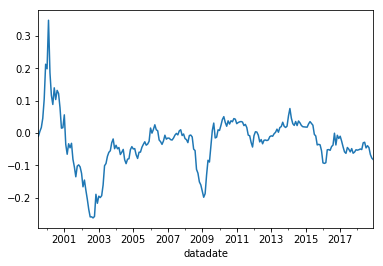

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.212797
2000-12-31   -0.161868
2001-12-31   -0.119400
2002-12-31   -0.125726
2003-12-31    0.215818
2004-12-31    0.006736
2005-12-31    0.017213
2006-12-31    0.006799
2007-12-31    0.016323
2008-12-31   -0.158094
2009-12-31    0.203123
2010-12-31    0.032590
2011-12-31   -0.082625
2012-12-31    0.033480
2013-12-31    0.032869
2014-12-31   -0.002322
2015-12-31   -0.072380
2016-12-31    0.040143
2017-12-31   -0.035470
2018-12-31   -0.032107
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     114.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.45e-53
Time:                        03:20:33   Log-Likelihood:                 648.21
No. Observations:                 234   AIC:                            -1286.
Df Residuals:                     229   BIC:                            -1269.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.536      0.593      -0.001       0.003
mktrf          0.0969      0.029      3.390      0.001       0.041       0.153
me             0.2493      0.033      7.497      0.000       0.184       0.315
ia            -0.2613      0.051     -5.172      0.000      -0.361      -0.162
roe           -0.3913      0.043     -9.046      0.000      -0.477      -0.306
==============================================================================
Omnibus:                       14.739   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               37.142
Skew:                           0.157   Prob(JB):                     8.60e-09
Kurtosis:                       4.926   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     44.55
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.22e-27
Time:                        03:20:33   Log-Likelihood:                 648.21
No. Observations:                 234   AIC:                            -1286.
Df Residuals:                     229   BIC:                            -1269.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.476      0.634      -0.002       0.003
mktrf          0.0969      0.035      2.791      0.005       0.029       0.165
me             0.2493      0.061      4.063      0.000       0.129       0.370
ia            -0.2613      0.088     -2.969      0.003      -0.434      -0.089
roe           -0.3913      0.079     -4.960      0.000      -0.546      -0.237
==============================================================================
Omnibus:                       14.739   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               37.142
Skew:                           0.157   Prob(JB):                     8.60e-09
Kurtosis:                       4.926   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     58.46
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.02e-34
Time:                        03:20:33   Log-Likelihood:                 648.21
No. Observations:                 234   AIC:                            -1286.
Df Residuals:                     229   BIC:                            -1269.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.511      0.609      -0.002       0.003
mktrf          0.0969      0.030      3.235      0.001       0.038       0.156
me             0.2493      0.062      3.995      0.000       0.127       0.372
ia            -0.2613      0.087     -3.020      0.003      -0.431      -0.092
roe           -0.3913      0.082     -4.799      0.000      -0.551      -0.231
==============================================================================
Omnibus:                       14.739   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               37.142
Skew:                           0.157   Prob(JB):                     8.60e-09
Kurtosis:                       4.926   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     106.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.63e-57
Time:                        03:20:33   Log-Likelihood:                 660.66
No. Observations:                 234   AIC:                            -1309.
Df Residuals:                     228   BIC:                            -1289.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.695      0.488      -0.001       0.003
mktrf          0.1239      0.027      4.552      0.000       0.070       0.178
smb            0.2259      0.036      6.291      0.000       0.155       0.297
hml           -0.0799      0.042     -1.887      0.060      -0.163       0.004
rmw           -0.4398      0.048     -9.186      0.000      -0.534      -0.345
cma           -0.0276      0.061     -0.453      0.651      -0.147       0.092
==============================================================================
Omnibus:                       13.742   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.103
Skew:                           0.314   Prob(JB):                     5.83e-06
Kurtosis:                       4.441   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     56.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.29e-38
Time:                        03:20:33   Log-Likelihood:                 660.66
No. Observations:                 234   AIC:                            -1309.
Df Residuals:                     228   BIC:                            -1289.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.707      0.480      -0.001       0.003
mktrf          0.1239      0.033      3.781      0.000       0.060       0.188
smb            0.2259      0.035      6.452      0.000       0.157       0.295
hml           -0.0799      0.073     -1.088      0.277      -0.224       0.064
rmw           -0.4398      0.064     -6.874      0.000      -0.565      -0.314
cma           -0.0276      0.075     -0.369      0.712      -0.174       0.119
==============================================================================
Omnibus:                       13.742   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.103
Skew:                           0.314   Prob(JB):                     5.83e-06
Kurtosis:                       4.441   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     80.17
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.80e-48
Time:                        03:20:33   Log-Likelihood:                 660.66
No. Observations:                 234   AIC:                            -1309.
Df Residuals:                     228   BIC:                            -1289.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.830      0.407      -0.001       0.002
mktrf          0.1239      0.036      3.458      0.001       0.054       0.194
smb            0.2259      0.036      6.306      0.000       0.156       0.296
hml           -0.0799      0.059     -1.349      0.177      -0.196       0.036
rmw           -0.4398      0.062     -7.038      0.000      -0.562      -0.317
cma           -0.0276      0.066     -0.418      0.676      -0.157       0.102
==============================================================================
Omnibus:                       13.742   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.103
Skew:                           0.314   Prob(JB):                     5.83e-06
Kurtosis:                       4.441   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     89.55
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-45
Time:                        03:20:33   Log-Likelihood:                 630.16
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1233.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.165      0.245      -0.003       0.001
mktrf          0.2086      0.028      7.340      0.000       0.153       0.265
smb            0.3920      0.035     11.048      0.000       0.322       0.462
hml           -0.1843      0.035     -5.228      0.000      -0.254      -0.115
umd           -0.0704      0.023     -3.044      0.003      -0.116      -0.025
==============================================================================
Omnibus:                       20.959   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.797
Skew:                           0.442   Prob(JB):                     5.09e-10
Kurtosis:                       4.900   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     36.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.73e-23
Time:                        03:20:33   Log-Likelihood:                 630.16
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1233.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.173      0.241      -0.003       0.001
mktrf          0.2086      0.037      5.625      0.000       0.136       0.281
smb            0.3920      0.062      6.294      0.000       0.270       0.514
hml           -0.1843      0.060     -3.074      0.002      -0.302      -0.067
umd           -0.0704      0.043     -1.619      0.105      -0.156       0.015
==============================================================================
Omnibus:                       20.959   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.797
Skew:                           0.442   Prob(JB):                     5.09e-10
Kurtosis:                       4.900   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     35.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.64e-23
Time:                        03:20:33   Log-Likelihood:                 630.16
No. Observations:                 234   AIC:                            -1250.
Df Residuals:                     229   BIC:                            -1233.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.370      0.171      -0.003       0.001
mktrf          0.2086      0.039      5.350      0.000       0.132       0.285
smb            0.3920      0.056      6.982      0.000       0.282       0.502
hml           -0.1843      0.061     -3.034      0.002      -0.303      -0.065
umd           -0.0704      0.043     -1.620      0.105      -0.156       0.015
==============================================================================
Omnibus:                       20.959   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.797
Skew:                           0.442   Prob(JB):                     5.09e-10
Kurtosis:                       4.900   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     63.12
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.94e-28
Time:                        03:20:33   Log-Likelihood:                 309.24
No. Observations:                 120   AIC:                            -608.5
Df Residuals:                     115   BIC:                            -594.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.463      0.644      -0.003       0.004
mktrf          0.1465      0.048      3.026      0.003       0.051       0.242
me             0.2761      0.048      5.773      0.000       0.181       0.371
ia            -0.3519      0.075     -4.699      0.000      -0.500      -0.204
roe           -0.2921      0.066     -4.407      0.000      -0.423      -0.161
==============================================================================
Omnibus:                        6.813   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.033   Jarque-Bera (JB):               11.195
Skew:                           0.138   Prob(JB):                      0.00371
Kurtosis:                       4.471   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     34.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.08e-19
Time:                        03:20:33   Log-Likelihood:                 309.24
No. Observations:                 120   AIC:                            -608.5
Df Residuals:                     115   BIC:                            -594.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.391      0.696      -0.003       0.005
mktrf          0.1465      0.056      2.603      0.009       0.036       0.257
me             0.2761      0.080      3.434      0.001       0.119       0.434
ia            -0.3519      0.115     -3.048      0.002      -0.578      -0.126
roe           -0.2921      0.117     -2.491      0.013      -0.522      -0.062
==============================================================================
Omnibus:                        6.813   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.033   Jarque-Bera (JB):               11.195
Skew:                           0.138   Prob(JB):                      0.00371
Kurtosis:                       4.471   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     50.24
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.16e-24
Time:                        03:20:33   Log-Likelihood:                 309.24
No. Observations:                 120   AIC:                            -608.5
Df Residuals:                     115   BIC:                            -594.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.414      0.679      -0.003       0.005
mktrf          0.1465      0.045      3.287      0.001       0.059       0.234
me             0.2761      0.084      3.280      0.001       0.111       0.441
ia            -0.3519      0.111     -3.183      0.001      -0.569      -0.135
roe           -0.2921      0.117     -2.488      0.013      -0.522      -0.062
==============================================================================
Omnibus:                        6.813   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.033   Jarque-Bera (JB):               11.195
Skew:                           0.138   Prob(JB):                      0.00371
Kurtosis:                       4.471   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     73.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.58e-34
Time:                        03:20:33   Log-Likelihood:                 325.83
No. Observations:                 120   AIC:                            -639.7
Df Residuals:                     114   BIC:                            -622.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.224      0.223      -0.001       0.005
mktrf          0.1731      0.045      3.876      0.000       0.085       0.262
smb            0.2300      0.051      4.547      0.000       0.130       0.330
hml           -0.1586      0.062     -2.559      0.012      -0.281      -0.036
rmw           -0.3645      0.073     -4.986      0.000      -0.509      -0.220
cma           -0.0222      0.080     -0.277      0.783      -0.181       0.136
==============================================================================
Omnibus:                        4.207   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.531
Skew:                           0.195   Prob(JB):                        0.104
Kurtosis:                       3.868   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     47.97
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.72e-26
Time:                        03:20:33   Log-Likelihood:                 325.83
No. Observations:                 120   AIC:                            -639.7
Df Residuals:                     114   BIC:                            -622.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.475      0.140      -0.001       0.005
mktrf          0.1731      0.050      3.488      0.000       0.076       0.270
smb            0.2300      0.050      4.644      0.000       0.133       0.327
hml           -0.1586      0.081     -1.950      0.051      -0.318       0.001
rmw           -0.3645      0.095     -3.839      0.000      -0.551      -0.178
cma           -0.0222      0.091     -0.243      0.808      -0.201       0.157
==============================================================================
Omnibus:                        4.207   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.531
Skew:                           0.195   Prob(JB):                        0.104
Kurtosis:                       3.868   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     67.33
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.06e-32
Time:                        03:20:33   Log-Likelihood:                 325.83
No. Observations:                 120   AIC:                            -639.7
Df Residuals:                     114   BIC:                            -622.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.830      0.067      -0.000       0.004
mktrf          0.1731      0.049      3.531      0.000       0.077       0.269
smb            0.2300      0.051      4.502      0.000       0.130       0.330
hml           -0.1586      0.064     -2.464      0.014      -0.285      -0.032
rmw           -0.3645      0.100     -3.639      0.000      -0.561      -0.168
cma           -0.0222      0.076     -0.293      0.769      -0.170       0.126
==============================================================================
Omnibus:                        4.207   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.531
Skew:                           0.195   Prob(JB):                        0.104
Kurtosis:                       3.868   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     70.07
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.13e-30
Time:                        03:20:33   Log-Likelihood:                 313.62
No. Observations:                 120   AIC:                            -617.2
Df Residuals:                     115   BIC:                            -603.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.194e-05      0.002     -0.037      0.971      -0.003       0.003
mktrf          0.2857      0.041      6.945      0.000       0.204       0.367
smb            0.3575      0.047      7.634      0.000       0.265       0.450
hml           -0.2518      0.047     -5.368      0.000      -0.345      -0.159
umd           -0.0296      0.029     -1.022      0.309      -0.087       0.028
==============================================================================
Omnibus:                        5.957   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                8.742
Skew:                           0.147   Prob(JB):                       0.0126
Kurtosis:                       4.289   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     40.47
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.94e-21
Time:                        03:20:33   Log-Likelihood:                 313.62
No. Observations:                 120   AIC:                            -617.2
Df Residuals:                     115   BIC:                            -603.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.194e-05      0.002     -0.039      0.969      -0.003       0.003
mktrf          0.2857      0.041      6.957      0.000       0.205       0.366
smb            0.3575      0.071      5.039      0.000       0.218       0.497
hml           -0.2518      0.055     -4.596      0.000      -0.359      -0.144
umd           -0.0296      0.044     -0.675      0.500      -0.115       0.056
==============================================================================
Omnibus:                        5.957   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                8.742
Skew:                           0.147   Prob(JB):                       0.0126
Kurtosis:                       4.289   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     52.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.53e-25
Time:                        03:20:33   Log-Likelihood:                 313.62
No. Observations:                 120   AIC:                            -617.2
Df Residuals:                     115   BIC:                            -603.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.194e-05      0.001     -0.049      0.961      -0.003       0.002
mktrf          0.2857      0.032      9.067      0.000       0.224       0.347
smb            0.3575      0.062      5.743      0.000       0.235       0.480
hml           -0.2518      0.043     -5.797      0.000      -0.337      -0.167
umd           -0.0296      0.040     -0.748      0.455      -0.107       0.048
==============================================================================
Omnibus:                        5.957   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                8.742
Skew:                           0.147   Prob(JB):                       0.0126
Kurtosis:                       4.289   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     57.95
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.98e-26
Time:                        03:20:33   Log-Likelihood:                 370.79
No. Observations:                 114   AIC:                            -731.6
Df Residuals:                     109   BIC:                            -717.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.639      0.524      -0.001       0.002
mktrf          0.0546      0.028      1.941      0.055      -0.001       0.110
me             0.1911      0.043      4.399      0.000       0.105       0.277
ia            -0.0624      0.060     -1.036      0.302      -0.182       0.057
roe           -0.5364      0.053    -10.131      0.000      -0.641      -0.431
==============================================================================
Omnibus:                       10.101   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.110
Skew:                           0.517   Prob(JB):                      0.00235
Kurtosis:                       4.217   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     36.04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.62e-19
Time:                        03:20:33   Log-Likelihood:                 370.79
No. Observations:                 114   AIC:                            -731.6
Df Residuals:                     109   BIC:                            -717.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.881      0.378      -0.001       0.002
mktrf          0.0546      0.028      1.974      0.048       0.000       0.109
me             0.1911      0.031      6.209      0.000       0.131       0.251
ia            -0.0624      0.078     -0.795      0.426      -0.216       0.091
roe           -0.5364      0.076     -7.069      0.000      -0.685      -0.388
==============================================================================
Omnibus:                       10.101   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.110
Skew:                           0.517   Prob(JB):                      0.00235
Kurtosis:                       4.217   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     46.26
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.15e-22
Time:                        03:20:33   Log-Likelihood:                 370.79
No. Observations:                 114   AIC:                            -731.6
Df Residuals:                     109   BIC:                            -717.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.986      0.324      -0.001       0.002
mktrf          0.0546      0.026      2.085      0.037       0.003       0.106
me             0.1911      0.032      6.055      0.000       0.129       0.253
ia            -0.0624      0.088     -0.706      0.480      -0.236       0.111
roe           -0.5364      0.069     -7.816      0.000      -0.671      -0.402
==============================================================================
Omnibus:                       10.101   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.110
Skew:                           0.517   Prob(JB):                      0.00235
Kurtosis:                       4.217   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     23.22
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.03e-16
Time:                        03:20:33   Log-Likelihood:                 347.42
No. Observations:                 114   AIC:                            -682.8
Df Residuals:                     108   BIC:                            -666.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.280      0.780      -0.003       0.002
mktrf          0.0840      0.033      2.539      0.013       0.018       0.150
smb            0.2423      0.054      4.510      0.000       0.136       0.349
hml            0.0317      0.069      0.463      0.644      -0.104       0.168
rmw           -0.3914      0.084     -4.665      0.000      -0.558      -0.225
cma            0.0274      0.107      0.257      0.798      -0.184       0.238
==============================================================================
Omnibus:                        6.040   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.557
Skew:                           0.452   Prob(JB):                       0.0621
Kurtosis:                       3.595   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     17.56
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-12
Time:                        03:20:34   Log-Likelihood:                 347.42
No. Observations:                 114   AIC:                            -682.8
Df Residuals:                     108   BIC:                            -666.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.310      0.757      -0.002       0.002
mktrf          0.0840      0.034      2.457      0.014       0.017       0.151
smb            0.2423      0.047      5.200      0.000       0.151       0.334
hml            0.0317      0.100      0.318      0.751      -0.164       0.227
rmw           -0.3914      0.118     -3.326      0.001      -0.622      -0.161
cma            0.0274      0.122      0.224      0.823      -0.213       0.267
==============================================================================
Omnibus:                        6.040   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.557
Skew:                           0.452   Prob(JB):                       0.0621
Kurtosis:                       3.595   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     27.08
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.15e-17
Time:                        03:20:34   Log-Likelihood:                 347.42
No. Observations:                 114   AIC:                            -682.8
Df Residuals:                     108   BIC:                            -666.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.364      0.716      -0.002       0.001
mktrf          0.0840      0.034      2.454      0.014       0.017       0.151
smb            0.2423      0.045      5.411      0.000       0.155       0.330
hml            0.0317      0.105      0.302      0.763      -0.174       0.238
rmw           -0.3914      0.107     -3.641      0.000      -0.602      -0.181
cma            0.0274      0.146      0.187      0.851      -0.259       0.314
==============================================================================
Omnibus:                        6.040   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.557
Skew:                           0.452   Prob(JB):                       0.0621
Kurtosis:                       3.595   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     23.36
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.81e-14
Time:                        03:20:34   Log-Likelihood:                 341.11
No. Observations:                 114   AIC:                            -672.2
Df Residuals:                     109   BIC:                            -658.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.503      0.616      -0.003       0.002
mktrf          0.0962      0.035      2.781      0.006       0.028       0.165
smb            0.3360      0.054      6.228      0.000       0.229       0.443
hml            0.0508      0.056      0.915      0.362      -0.059       0.161
umd           -0.1234      0.042     -2.945      0.004      -0.207      -0.040
==============================================================================
Omnibus:                        9.096   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               10.986
Skew:                           0.461   Prob(JB):                      0.00411
Kurtosis:                       4.209   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     17.07
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.72e-11
Time:                        03:20:34   Log-Likelihood:                 341.11
No. Observations:                 114   AIC:                            -672.2
Df Residuals:                     109   BIC:                            -658.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.681      0.496      -0.002       0.001
mktrf          0.0962      0.035      2.749      0.006       0.028       0.165
smb            0.3360      0.053      6.344      0.000       0.232       0.440
hml            0.0508      0.097      0.522      0.602      -0.140       0.242
umd           -0.1234      0.039     -3.186      0.001      -0.199      -0.047
==============================================================================
Omnibus:                        9.096   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               10.986
Skew:                           0.461   Prob(JB):                      0.00411
Kurtosis:                       4.209   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     23.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.45e-14
Time:                        03:20:34   Log-Likelihood:                 341.11
No. Observations:                 114   AIC:                            -672.2
Df Residuals:                     109   BIC:                            -658.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.798      0.425      -0.002       0.001
mktrf          0.0962      0.034      2.832      0.005       0.030       0.163
smb            0.3360      0.042      8.013      0.000       0.254       0.418
hml            0.0508      0.103      0.494      0.621      -0.151       0.252
umd           -0.1234      0.035     -3.557      0.000      -0.191      -0.055
==============================================================================
Omnibus:                        9.096   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               10.986
Skew:                           0.461   Prob(JB):                      0.00411
Kurtosis:                       4.209   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""